In [2]:
import random
import math
import matplotlib.pyplot as plt
import time
import numpy as np
from point import Point

Same pool of trials for all participants (static), with different shuffling (dynamic).

---

# Static Layout Pool
This refers to the generation of the layout pool, which will be the same for ALL participants.

## Generation

- Given N trials, we produce  N/2 pairs of layouts.
    - Between these pairs, we keep the same coordinates for the points, and the same order of navigation.
    - One of these pairs is the no-boundary-show, the other is the boundary-shown. The layout is rotated between these two.
    - Per layout, we have 5 objects and an ending location. The first object is also the starting location and might be asked.
    - We do not want any 2 objects to be too close to each other.
    - We do not want any path to be too short. We do not have an upper bound on the travel distance.
    - We want to to make sure that there is at least one object on both sides.

In [3]:
N_POINTS_LAYOUT = 6 # 5 objects, one of which is the starting location, and an ending location
N_LAYOUTS = 50 # generate this many layouts. each layout produces a pair (visible/invisible boundary)

# these are currently arbitrary units that we can scale up and down as needed
# w=5, l=10 represents a 1 by 2 rectangle room
WIDTH = 5 
LENGTH = 10

ASPECT = LENGTH / WIDTH

# this is the minimum distance any two objects (not a path) can have. 
# used to prevent objects appearing too close and confusing participants
MIN_DIST_OBJECTS = 1.5

# this is the minimum path distance. no subsequent object should appear closer than this.
# greater than MIN_DIST_OBJECTS because objects appearing too close also means they are visited too soon and not enough time to learn that object
MIN_DIST_PATH = 2.3

In [4]:
def generate_random_layout():
    return [Point.random_rect(WIDTH, LENGTH) for p in range(N_POINTS_LAYOUT)]

def has_valid_margin(p):
    buffer = 0.05
    x_lo = buffer * WIDTH
    x_hi = (1 - buffer) * WIDTH
    
    y_lo = buffer * LENGTH
    y_hi = (1 - buffer) * LENGTH
    
    border_lo = (LENGTH / 2) - LENGTH * buffer
    border_hi = (LENGTH / 2) + LENGTH * buffer
    
    bufferFromBoundary = (x_lo < p.x < x_hi) and (y_lo < p.y < y_hi)
    bufferFromBorder = not (border_lo < p.y < border_hi)
    
    return bufferFromBoundary and bufferFromBorder

def is_valid_layout(lay):
    
    # check all distance constraints, (dist between objects and path distances)
    for i in range(len(lay)):
        for j in range(i):
            # if these points are adjacent, check for path distance condition, otherwise object distance condition
            lower_bound = MIN_DIST_PATH if j == i - 1 else MIN_DIST_OBJECTS
            if lay[i].dist(lay[j]) <= lower_bound:
                return False
    
    # check that there is at least one object on each side
    # note that this checks for objects ONLY (that is; not the last point which is the ending/task location)
    objects_on_lower_side = sum([1 if l.y < LENGTH / 2 else 0 for l in lay[:N_POINTS_LAYOUT-1]])
    if not ( 1 <= objects_on_lower_side < N_POINTS_LAYOUT-1):
        # either 0 or N_POINTS_LAYOUT-1 on this side, which means the reverse for the other side. not valid!
        return False
    
    for p in lay:
        if not has_valid_margin(p):
            return False
    
    return True

def generate_valid_layout():
    candidate = generate_random_layout()
    c = 0
    while not is_valid_layout(candidate):
        c += 1
        if c == 1e5:
            print("can not find valid layout!")
            return None
        candidate = generate_random_layout()
    return candidate

In [5]:
layouts = []
for l in range(N_LAYOUTS):
    layouts.append(generate_valid_layout())

In [6]:
print(layouts)

[[P(4.27, 1.46), P(1.87, 7.82), P(4.66, 4.35), P(2.02, 4.04), P(3.7, 9.03), P(1.89, 1.8)], [P(0.9, 7.01), P(3.54, 6.15), P(1.24, 8.93), P(1.92, 0.93), P(3.0, 8.11), P(0.35, 4.39)], [P(3.42, 8.74), P(1.23, 2.86), P(0.99, 8.01), P(1.87, 0.69), P(2.53, 7.47), P(4.64, 1.11)], [P(1.34, 3.61), P(3.94, 2.42), P(3.91, 6.43), P(0.66, 7.53), P(4.14, 4.29), P(3.67, 8.27)], [P(3.53, 4.26), P(0.39, 3.54), P(4.54, 0.9), P(4.69, 5.71), P(2.95, 0.63), P(0.47, 5.6)], [P(2.77, 7.5), P(1.42, 1.27), P(4.64, 3.13), P(1.78, 2.77), P(4.63, 7.91), P(0.59, 5.91)], [P(2.62, 0.65), P(3.29, 3.88), P(2.82, 8.87), P(1.9, 2.54), P(0.93, 7.46), P(4.64, 6.24)], [P(2.73, 5.81), P(1.87, 2.78), P(1.63, 8.69), P(0.79, 1.58), P(4.55, 3.15), P(2.53, 0.73)], [P(0.71, 9.21), P(3.98, 8.64), P(1.59, 1.46), P(2.47, 7.8), P(2.39, 2.74), P(4.29, 7.16)], [P(4.35, 7.21), P(4.72, 1.22), P(1.4, 7.03), P(4.17, 3.93), P(1.0, 3.74), P(1.19, 0.86)], [P(2.6, 6.15), P(4.13, 4.43), P(0.37, 8.38), P(0.33, 0.51), P(4.07, 6.6), P(1.88, 8.1)], [

## Checks
- We want to check for the following distributions:
    - Pointing ground-truths -> compare those in the same side and across the boundary.
    - How much they have traveled
    - Distances between any two objects
    
- And the following are nice sanity checks to have:
    - Plot of all layouts
    - Plot of all points

In [7]:
# Ground Truth for Pointing Tasks (GTPT)
gtpt_same = []
gtpt_cross = []

for lay in layouts:
    last = lay[-1]
    last_side = last.y < LENGTH / 2
    
    for obj in lay[:-1]:
        is_on_same_side = last_side == (obj.y < LENGTH / 2)
        dist = last.dist(obj)
        if is_on_same_side:
            gtpt_same.append(dist)
        else:
            gtpt_cross.append(dist)

gtpt_all = [gtpt_same, gtpt_cross]
print(len(gtpt_same), "same side; ", len(gtpt_cross), "across boundary")

110 same side;  140 across boundary


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


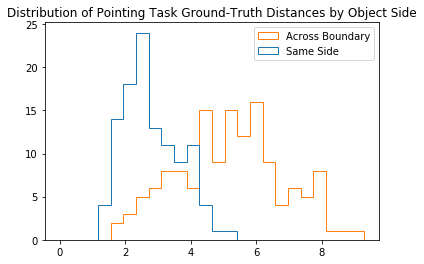

In [8]:
plt.hist(gtpt_all, bins = 24, range = [0, max(gtpt_same + gtpt_cross)] ,histtype='step', stacked=False, fill=False, label = ["Same Side", "Across Boundary"])
plt.legend(prop={'size': 10})
plt.title("Distribution of Pointing Task Ground-Truth Distances by Object Side")
plt.show()

In [9]:
# Travel Distance (TD)

td_same = []
td_cross_real = []
td_cross_bird = []

for lay in layouts:
    for i in range(len(lay) - 1):
        prev_side = lay[i].y < LENGTH / 2
        next_side = lay[i+1].y < LENGTH / 2
        is_on_same_side = prev_side == next_side
        if is_on_same_side:
            td_same.append(lay[i].dist(lay[i+1]))
        else:
            mid_point = Point(WIDTH / 2, LENGTH / 2)
            full_dist = lay[i].dist(mid_point) + mid_point.dist(lay[i+1])
            td_cross_real.append(full_dist)
            td_cross_bird.append(lay[i].dist(lay[i+1]))
        
td_all = [td_same, td_cross_real, td_cross_bird]
print(len(td_same), "same side; ", len(td_cross_real), "across boundary")

93 same side;  157 across boundary


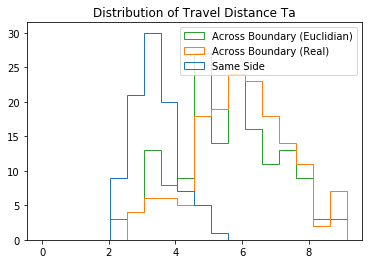

In [10]:
plt.hist(td_all, bins = 18, range = [0, max(td_same + td_cross_real + td_cross_bird)], histtype='step', stacked=False, fill=False, label = ["Same Side", "Across Boundary (Real)", "Across Boundary (Euclidian)"])
plt.legend(prop={'size': 10})
plt.title("Distribution of Travel Distance Ta")
plt.show()

In [11]:
# Object Distance (OD)
od_all = []

for lay in layouts:
    for i in range(len(lay)):
        for j in range(i):
            od_all.append(lay[i].dist(lay[j]))

print(f"{len(od_all)} object distances")

750 object distances


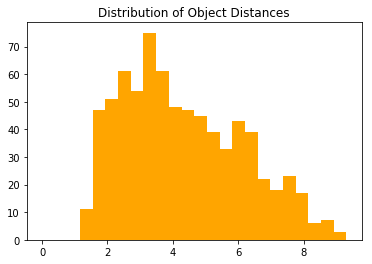

In [12]:
plt.hist(od_all, bins = 24, range = [0, max(od_all)], color = "orange")
plt.title("Distribution of Object Distances")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


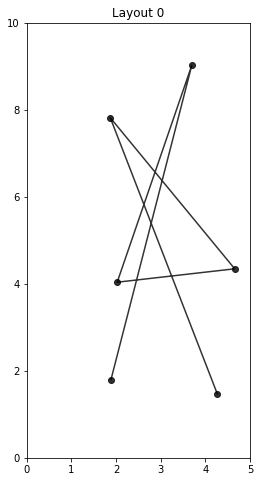

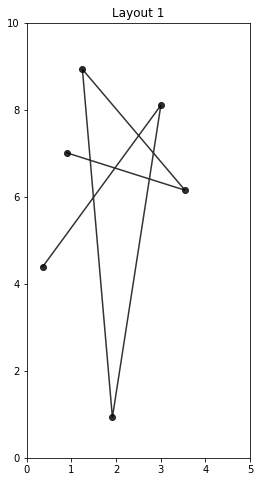

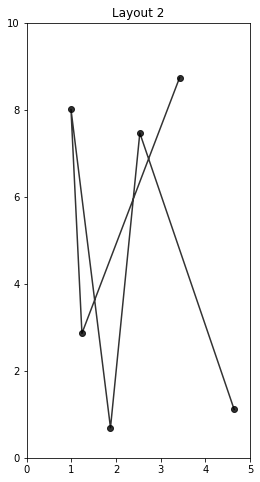

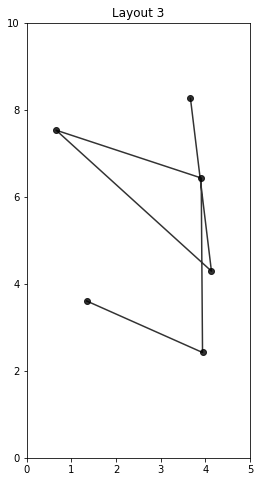

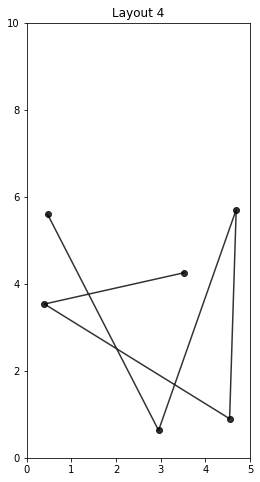

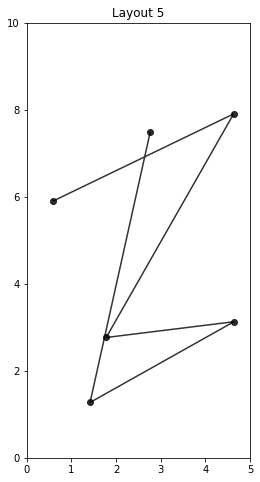

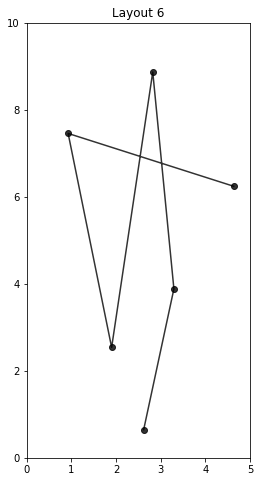

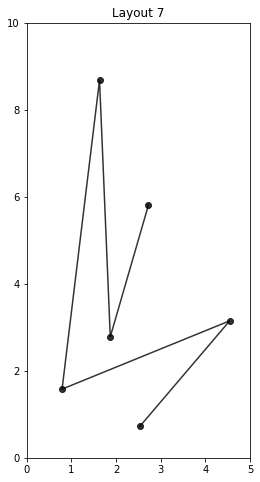

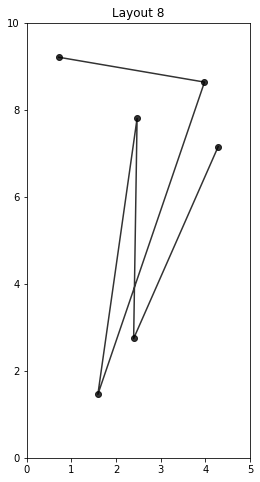

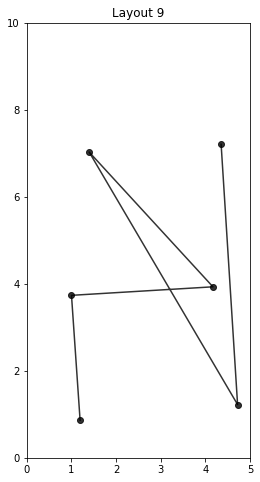

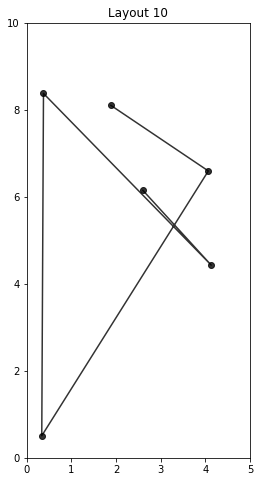

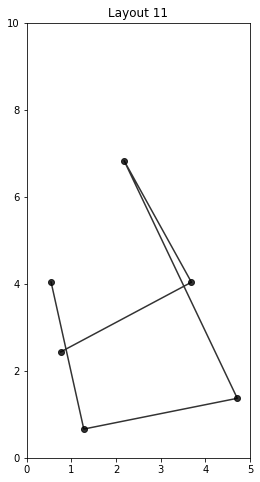

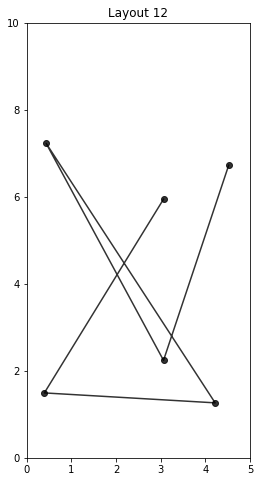

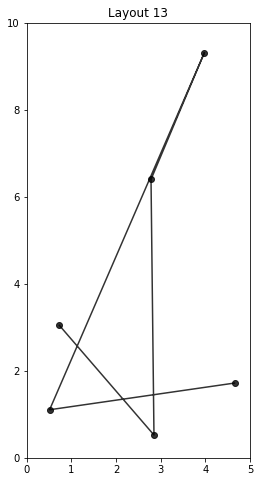

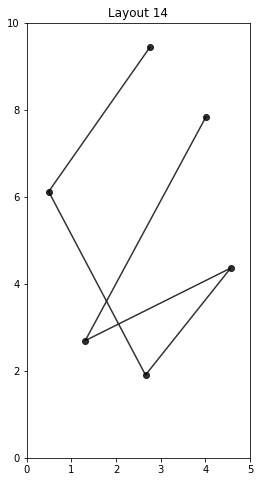

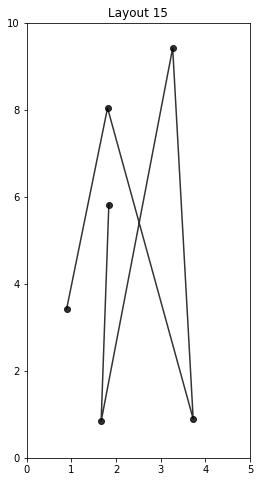

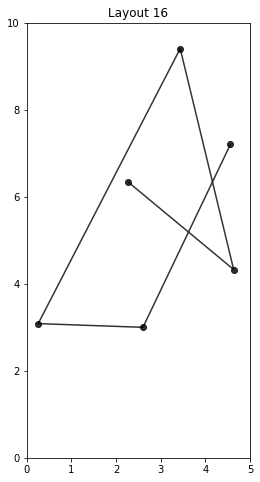

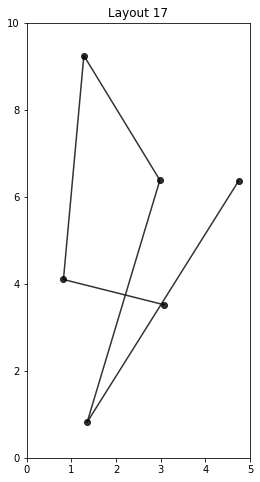

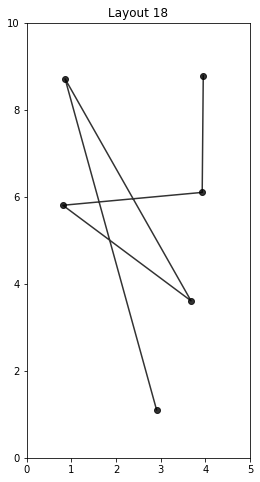

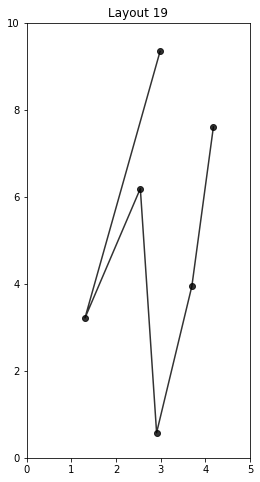

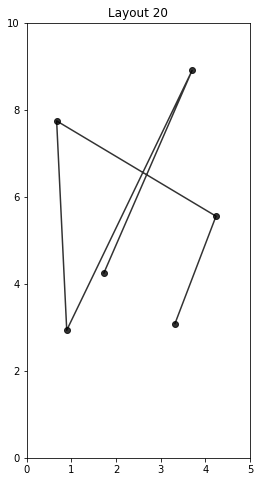

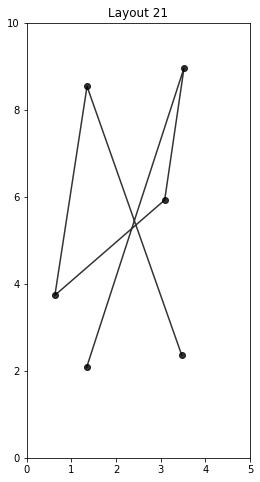

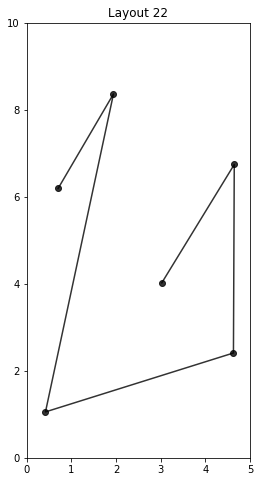

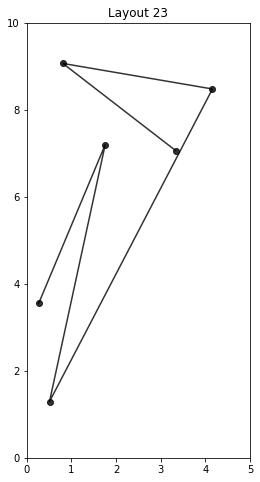

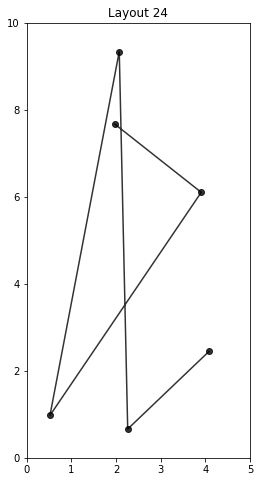

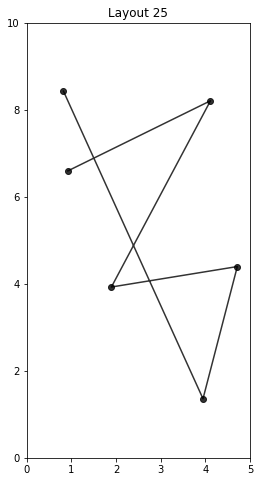

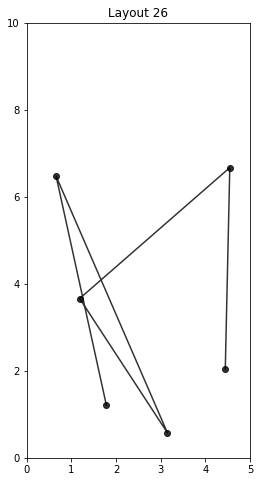

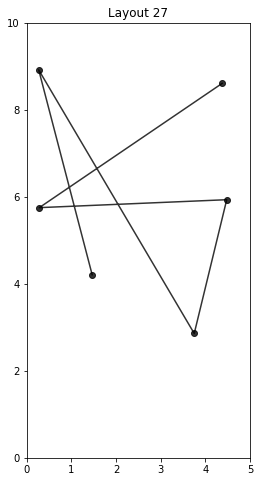

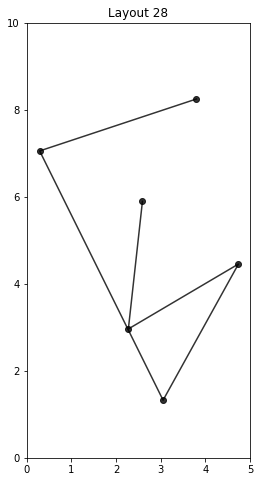

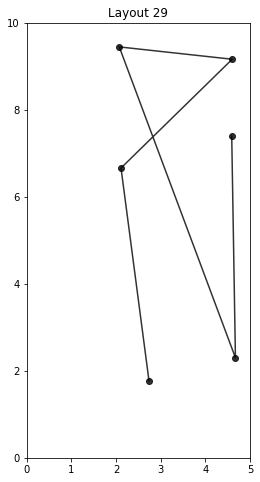

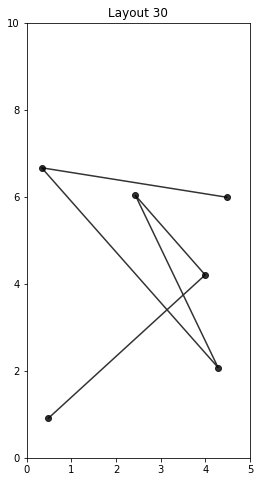

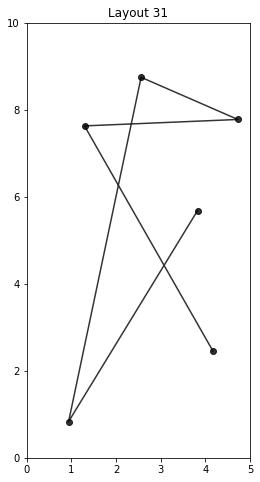

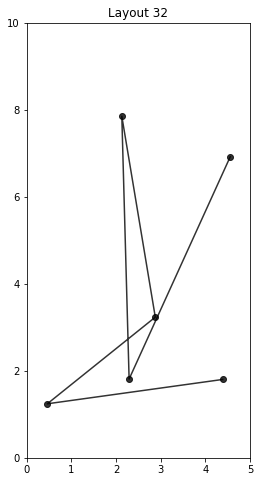

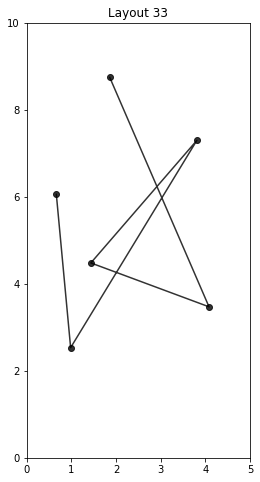

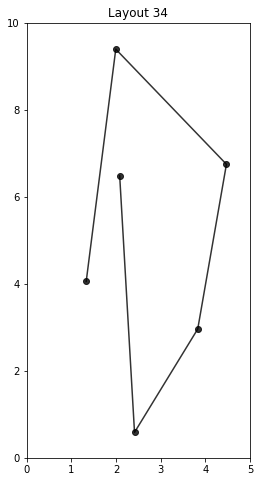

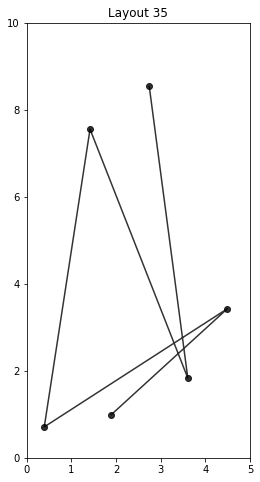

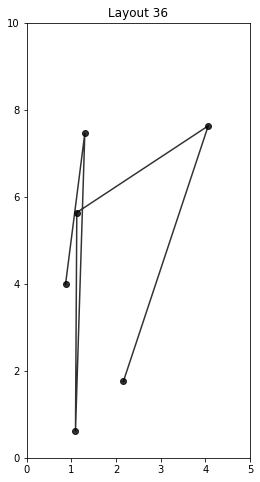

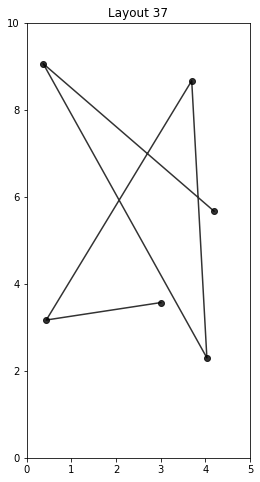

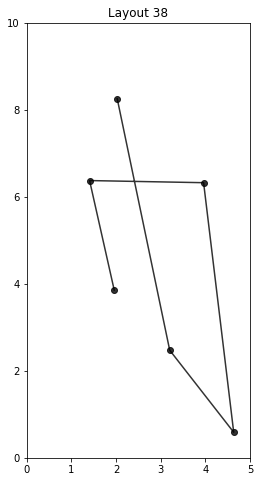

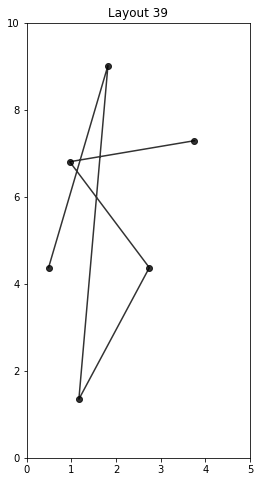

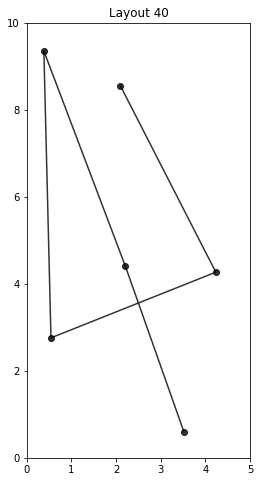

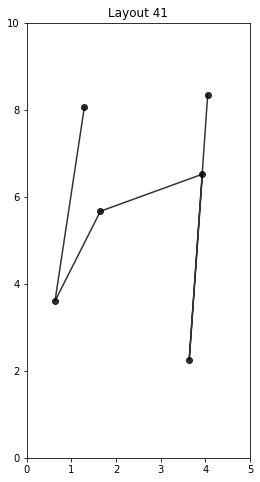

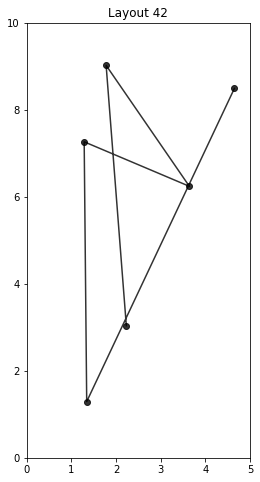

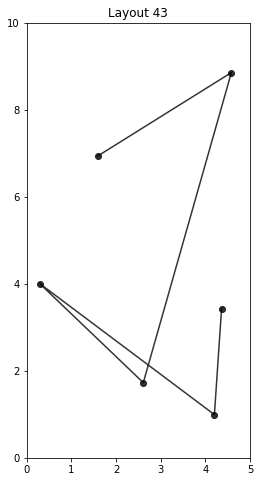

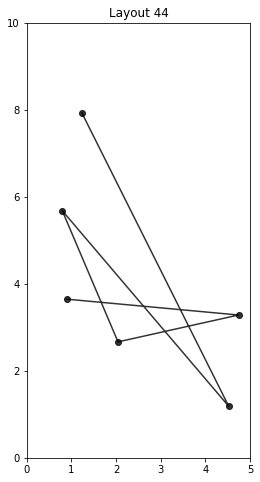

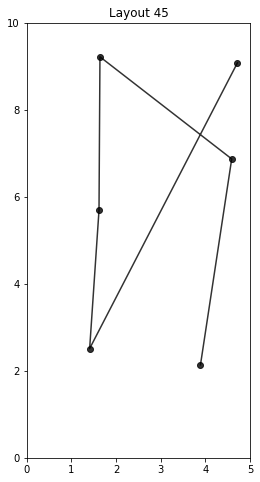

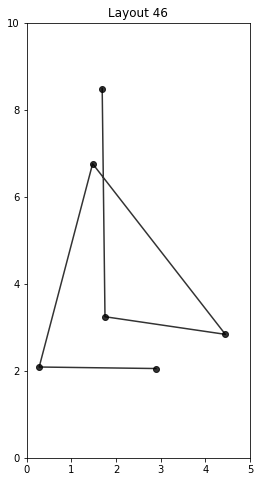

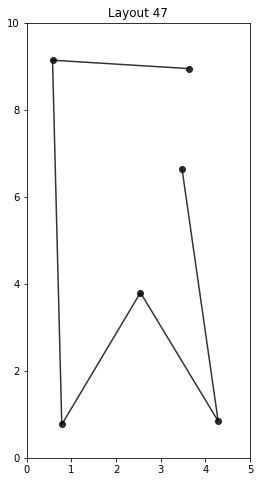

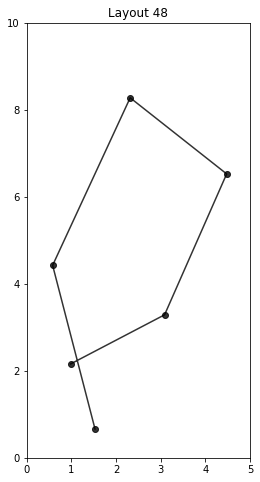

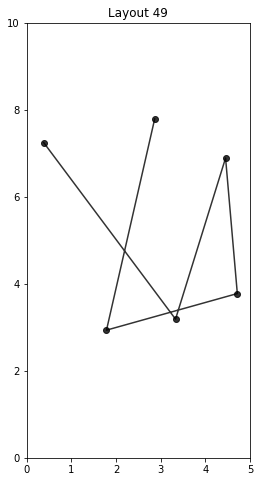

In [13]:
for i, lay in enumerate(layouts):
    fig, axs = plt.subplots(figsize = (4, 8))
    plt.plot([p.x for p in lay], [p.y for p in lay], "k-o", alpha = 0.8)
    plt.xlim([0, WIDTH])
    plt.ylim([0, LENGTH])
    plt.title(f"Layout {i}")

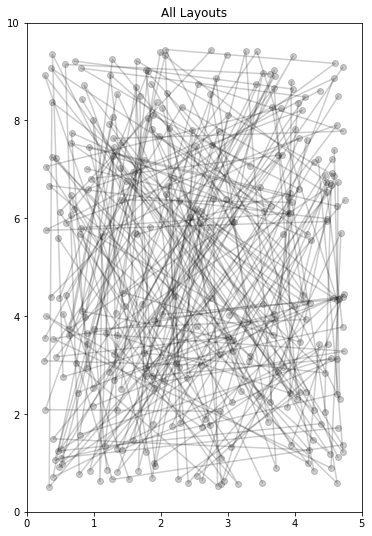

In [14]:
fig, axs = plt.subplots(figsize = (6, 9))
for lay in layouts:
    plt.plot([p.x for p in lay], [p.y for p in lay], "k-o", alpha = 0.2)
plt.title("All Layouts")
plt.xlim([0, WIDTH])
plt.ylim([0, LENGTH])
plt.show()

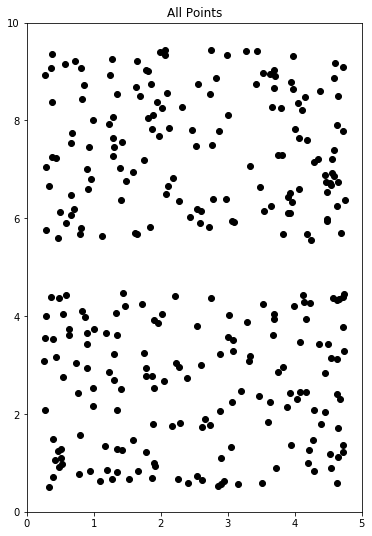

In [15]:
fig, axs = plt.subplots(figsize = (6, 9))
for lay in layouts:
    plt.scatter([p.x for p in lay], [p.y for p in lay], color = "k")
plt.title("All Points")
plt.xlim([0, WIDTH])
plt.ylim([0, LENGTH])
plt.show()

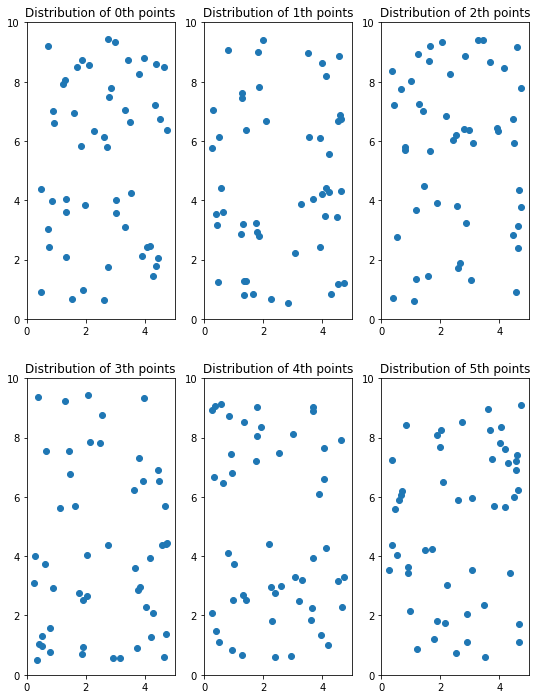

In [16]:
# Distribution of different points in a layout sequence
fig, axs = plt.subplots(2, 3, figsize = (9, 12))
for i in range(N_POINTS_LAYOUT):
    ith_ps = [layouts[j][i] for j in range(N_LAYOUTS)]
    xs, ys = [p.x for p in ith_ps], [p.y for p in ith_ps]
    axs[i//3, i%3].scatter(xs, ys)
    axs[i//3, i%3].set_xlim([0, WIDTH])
    axs[i//3, i%3].set_ylim([0, LENGTH])
    axs[i//3, i%3].set_title(f"Distribution of {i}th points")

# Save Data
- These will be shuffled by the v3_dynamic notebook

In [17]:
import json

layout_out = {"width": WIDTH, "length": LENGTH, "layouts": [[[p.x, p.y] for p in lay] for lay in layouts]}
with open("data/static_layout_pool.json", "w") as outfile:
    outfile.write(json.dumps(layout_out))